In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18771.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18775.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18765.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18773.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18781.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18770.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18769.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18780.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18774.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18772.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18767.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18782.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18779.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18766.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18776.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18778.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18768.jpg
/kaggle/input/

In [2]:
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q segmentation-models-pytorch albumentations opencv-python pandas matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Import and paths
import os, glob, random, numpy as np, pandas as pd, cv2, torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(42)

# paths
VAL_IMAGE_DIR = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images"
VAL_MASK_DIR  = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Masks"
OUT_DIR = "/kaggle/working/"
RESULT_DIR = "/kaggle/input/resnet34-unet-segmentation-output/unet_results"          
BEST_CKPT     = os.path.join(RESULT_DIR, "best_unet_resnet34.pth")
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 512
BATCH_SIZE = 8

In [4]:
# Dataset and Val loader
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

def list_images(d):
    return sorted([p for e in IMG_EXTS for p in glob.glob(os.path.join(d, f"*{e}"))])

def mask_for(img_path, mask_dir):
    name = os.path.splitext(os.path.basename(img_path))[0]
    for e in IMG_EXTS:
        p = os.path.join(mask_dir, name + e)
        if os.path.exists(p): return p
    return None

class SicapDataset(Dataset):
    def __init__(self, img_dir, mask_dir, aug=None):
        self.imgs = list_images(img_dir)
        self.pairs = []
        for ip in self.imgs:
            mp = mask_for(ip, mask_dir)
            if mp is not None: self.pairs.append((ip, mp))
        self.aug = aug

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(ip, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        m   = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)

        # robust binarization
        _, m = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        m = (m > 0).astype(np.uint8)

        if self.aug:
            sample = self.aug(image=img, mask=m)
            img, m = sample["image"], sample["mask"]

        img = img.float() / 255.0

        # Ensure mask is a torch tensor with shape 1xHxW
        if isinstance(m, np.ndarray):
            m = torch.from_numpy(m)
            m = m.unsqueeze(0).float()

        return img, m


val_tf = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT),
    ToTensorV2(),
])

val_ds = SicapDataset(VAL_IMAGE_DIR, VAL_MASK_DIR, aug=val_tf)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True, drop_last=False)
len(val_ds)

18

In [5]:
# Model
model = smp.Unet(encoder_name="resnet34",
                 encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

# load checkpoint
state = torch.load(BEST_CKPT, map_location=DEVICE)
if "state_dict" in state: state = state["state_dict"]
model.load_state_dict(state)
model.eval();
print("Loaded:", BEST_CKPT)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

/tmp/ipykernel_19/1653444666.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(BEST_CKPT, map_location=DEVICE)


Loaded: /kaggle/input/resnet34-unet-segmentation-output/unet_results/best_unet_resnet34.pth


In [6]:
# Post processing and threshold sweep
def clean_small(pred_mask, min_area=500):
    m = (pred_mask>0).astype(np.uint8)
    num, lab, stats, _ = cv2.connectedComponentsWithStats(m, 8)
    keep = np.zeros_like(m)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            keep[lab==i] = 1
    return keep

@torch.no_grad()
def sweep_threshold(model, loader, device, grid=np.linspace(0.40, 0.80, 21), min_blob_area=500):
    model.eval()
    all_logits, all_masks = [], []
    for imgs, masks in loader:
        imgs = imgs.to(device)
        all_logits.append(model(imgs).cpu())
        all_masks.append(masks.cpu().float())
    logits = torch.cat(all_logits, 0)
    masks  = torch.cat(all_masks,  0).numpy()

    def metrics(th):
        preds = (torch.sigmoid(logits) > th).float().numpy()
        tps=fps=fns=0
        for i in range(preds.shape[0]):
            pr = clean_small(preds[i,0].astype(np.uint8), min_blob_area)
            gt = masks[i,0].astype(np.uint8)
            tp = int(((pr==1)&(gt==1)).sum()); fp = int(((pr==1)&(gt==0)).sum()); fn = int(((pr==0)&(gt==1)).sum())
            tps+=tp; fps+=fp; fns+=fn
        precision = tps/(tps+fps+1e-7); recall = tps/(tps+fns+1e-7)
        dice = (2*tps)/(2*tps+fps+fns+1e-7)
        return precision, recall, dice

    table = [(float(th),)+metrics(float(th)) for th in grid]
    best_by_dice = max(table, key=lambda x: x[3])
    best_by_prec = max(table, key=lambda x: x[1])
    print("Best Dice      (thr, P, R, D):", tuple(round(v,4) for v in best_by_dice))
    print("Best Precision (thr, P, R, D):", tuple(round(v,4) for v in best_by_prec))
    return table, best_by_dice, best_by_prec

# run sweep (or set your own thr)
table, best_dice, best_prec = sweep_threshold(model, val_loader, DEVICE)
best_thr = best_dice[0]     # or: best_prec[0] to prefer fewer FPs
print("Chosen threshold:", round(best_thr,3))

Best Dice      (thr, P, R, D): (0.4, 0.669, 0.5847, 0.624)
Best Precision (thr, P, R, D): (0.8, 0.7248, 0.4627, 0.5649)
Chosen threshold: 0.4


In [7]:
# Evaluation
@torch.no_grad()
def eval_metrics(model, loader, device, thr=0.5, min_blob_area=500):
    model.eval()
    rows=[]; TP=FP=FN=0
    for idx, (imgs, masks) in enumerate(tqdm(loader, desc="Evaluating", unit="batch")):
        imgs = imgs.to(device)
        preds = (torch.sigmoid(model(imgs)) > thr).float().cpu().numpy()
        gts   = masks.cpu().numpy().astype(np.uint8)

        for i in range(preds.shape[0]):
            pr = clean_small(preds[i,0].astype(np.uint8), min_blob_area)
            gt = gts[i,0]
            tp = int(((pr==1)&(gt==1)).sum()); fp = int(((pr==1)&(gt==0)).sum()); fn = int(((pr==0)&(gt==1)).sum())
            precision = tp/(tp+fp+1e-7); recall = tp/(tp+fn+1e-7)
            dice = (2*tp)/(2*tp+fp+fn+1e-7); iou = tp/(tp+fp+fn+1e-7)
            rows.append({"index": idx*loader.batch_size+i, "dice":dice, "iou":iou,
                         "precision":precision, "recall":recall, "gt_empty": int(gt.sum()==0),
                         "tp":tp, "fp":fp, "fn":fn})
            TP+=tp; FP+=fp; FN+=fn

    df = pd.DataFrame(rows)
    macro = { "dice_macro": df["dice"].mean(),
              "iou_macro": df["iou"].mean(),
              "precision_macro": df["precision"].mean(),
              "recall_macro": df["recall"].mean() }

    pos = df[df["gt_empty"]==0]
    pos_macro = {
        "dice_pos": pos["dice"].mean() if len(pos) else np.nan,
        "iou_pos": pos["iou"].mean() if len(pos) else np.nan,
        "precision_pos": pos["precision"].mean() if len(pos) else np.nan,
        "recall_pos": pos["recall"].mean() if len(pos) else np.nan,
    }

    micro = { "dice_micro": (2*TP)/(2*TP+FP+FN+1e-7),
              "iou_micro":  TP/(TP+FP+FN+1e-7),
              "precision_micro": TP/(TP+FP+1e-7),
              "recall_micro":    TP/(TP+FN+1e-7) }

    return df, macro, pos_macro, micro

df_val, macro, pos_macro, micro = eval_metrics(model, val_loader, DEVICE, thr=best_thr, min_blob_area=500)
csv_path = os.path.join(OUT_DIR, "val_metrics_dice_iou_prec_rec.csv")
df_val.to_csv(csv_path, index=False)

print(f"\nThreshold used: {best_thr:.3f}")
print("Macro:", {k:f'{v:.4f}' for k,v in macro.items()})
print("Positives-only:", {k:f'{v:.4f}' for k,v in pos_macro.items()})
print("Micro:", {k:f'{v:.4f}' for k,v in micro.items()})
print("Saved per-image CSV ->", csv_path)

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.05batch/s]



Threshold used: 0.400
Macro: {'dice_macro': '0.4702', 'iou_macro': '0.3492', 'precision_macro': '0.5436', 'recall_macro': '0.4643'}
Positives-only: {'dice_pos': '0.5290', 'iou_pos': '0.3929', 'precision_pos': '0.6116', 'recall_pos': '0.5224'}
Micro: {'dice_micro': '0.6240', 'iou_micro': '0.4535', 'precision_micro': '0.6690', 'recall_micro': '0.5847'}
Saved per-image CSV -> /kaggle/working/val_metrics_dice_iou_prec_rec.csv


In [8]:
# Save overlays
@torch.no_grad()
def save_overlays_with_scores(model, loader, save_dir, device, thr=0.5, max_batches=3, min_blob_area=500):
    os.makedirs(save_dir, exist_ok=True)
    model.eval(); count = 0

    for b, (imgs, masks) in enumerate(loader):
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > thr).float().cpu().numpy()  # (B,1,H,W) or (B,H,W)
        imgs_np  = (imgs.cpu().numpy()*255).clip(0,255).astype(np.uint8).transpose(0,2,3,1)  # (B,H,W,3)
        masks_np = masks.cpu().numpy()  # usually (B,1,H,W)

        for i in range(imgs_np.shape[0]):
            img = imgs_np[i]

            # --- get GT as 2D (H,W) ---
            gt = masks_np[i]
            if gt.ndim == 3:   # (1,H,W) or (H,W,1)
                gt = gt[0] if gt.shape[0] in (1,) else np.squeeze(gt)
            gt = np.squeeze(gt)
            if gt.ndim != 2:
                # last resort: infer H,W from image
                H, W = img.shape[:2]
                gt = gt.reshape(H, W)
            gt = gt.astype(np.uint8)

            # get pred as 2D (H,W)
            pr = preds[i]
            if pr.ndim == 3:
                pr = pr[0] if pr.shape[0] in (1,) else np.squeeze(pr)
            pr = np.squeeze(pr).astype(np.uint8)

            # post-proc
            pr = clean_small(pr, min_blob_area)

            # per-image metrics
            tp = int(((pr==1) & (gt==1)).sum())
            fp = int(((pr==1) & (gt==0)).sum())
            fn = int(((pr==0) & (gt==1)).sum())
            dice = (2*tp) / (2*tp + fp + fn + 1e-7)
            iou  = tp / (tp + fp + fn + 1e-7)

            # overlay
            color = img.copy()
            red = np.zeros_like(color); red[...,0] = 255
            overlay = color.copy()
            overlay[pr==1] = (0.6*color[pr==1] + 0.4*red[pr==1]).astype(np.uint8)

            # robust GT RGB
            gt_rgb = np.repeat((gt[..., None] * 255).astype(np.uint8), 3, axis=2)  # (H,W,3)

            panel = np.concatenate([color, gt_rgb, overlay], axis=1)
            cv2.putText(panel, f"Dice {dice:.3f} | IoU {iou:.3f} | thr {thr:.2f}",
                        (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

            cv2.imwrite(os.path.join(save_dir, f"sample_{count:03d}.png"),
                        cv2.cvtColor(panel, cv2.COLOR_RGB2BGR))
            count += 1

        if max_batches is not None and (b+1) >= max_batches:
            break

In [9]:
save_overlays_with_scores(model, val_loader,
                          os.path.join(OUT_DIR, "figs_val"),
                          DEVICE, thr=best_thr, max_batches=3, min_blob_area=500)
print("Saved examples to:", os.path.join(OUT_DIR, "figs_val"))

Saved examples to: /kaggle/working/figs_val


In [10]:
# Cache logits and masks
import torch, numpy as np, os
from tqdm import tqdm

@torch.no_grad()
def cache_val_logits_masks(model, loader, device):
    model.eval()
    all_logits, all_masks = [], []
    for imgs, masks in tqdm(loader, desc="Caching val", unit="batch"):
        imgs = imgs.to(device)
        logits = model(imgs).detach().cpu()        # (B,1,H,W)
        all_logits.append(logits)
        all_masks.append(masks.detach().cpu())     # (B,1,H,W)
    return torch.cat(all_logits, 0), torch.cat(all_masks, 0)

logits_val, masks_val = cache_val_logits_masks(model, val_loader, DEVICE)
print(logits_val.shape, masks_val.shape)

Caching val: 100%|██████████| 3/3 [00:00<00:00,  6.13batch/s]

torch.Size([18, 1, 512, 512]) torch.Size([18, 512, 512])


In [11]:
# Sweep thresholds and compute metrics
import numpy as np

def _to_hw(x):
    x = x.squeeze(1) if x.ndim==4 else x
    return x

def _postproc(pred, min_blob_area=500):
    # pred is np.uint8 (0/1)
    return clean_small(pred, min_blob_area)  # pass as positional argument

def compute_metrics_over_thresholds(logits, masks, thr_grid=np.linspace(0.05,0.95,19), min_blob_area=500):
    # logits, masks are torch tensors on CPU: (N,1,H,W)
    logits = logits.clone()
    masks  = masks.clone().float()
    N, _, H, W = logits.shape

    masks_np = _to_hw(masks.numpy()).astype(np.uint8)  # (N,H,W)

    results = []
    for th in thr_grid:
        preds = (torch.sigmoid(logits) > float(th)).float()
        preds_np = _to_hw(preds.numpy()).astype(np.uint8)

        TP=FP=FN=0
        dices=[]; ious=[]; precs=[]; recs=[]
        dice_pos=[]; iou_pos=[]; prec_pos=[]; rec_pos=[]
        for i in range(N):
            pr = _postproc(preds_np[i], min_blob_area=min_blob_area)
            gt = masks_np[i]

            tp = int(((pr==1) & (gt==1)).sum())
            fp = int(((pr==1) & (gt==0)).sum())
            fn = int(((pr==0) & (gt==1)).sum())

            precision = tp/(tp+fp+1e-7)
            recall    = tp/(tp+fn+1e-7)
            dice      = (2*tp)/(2*tp+fp+fn+1e-7)
            iou       = tp/(tp+fp+fn+1e-7)

            precs.append(precision); recs.append(recall)
            dices.append(dice); ious.append(iou)

            if gt.sum() > 0:  # positives-only per-image
                prec_pos.append(precision); rec_pos.append(recall)
                dice_pos.append(dice); iou_pos.append(iou)

            TP+=tp; FP+=fp; FN+=fn

        # macro (per-image mean, includes negatives)
        precision_macro = float(np.mean(precs))
        recall_macro    = float(np.mean(recs))
        dice_macro      = float(np.mean(dices))
        iou_macro       = float(np.mean(ious))

        # positives-only macro
        precision_pos = float(np.mean(prec_pos)) if len(prec_pos) else np.nan
        recall_pos    = float(np.mean(rec_pos))  if len(rec_pos)  else np.nan
        dice_pos_m    = float(np.mean(dice_pos)) if len(dice_pos) else np.nan
        iou_pos_m     = float(np.mean(iou_pos))  if len(iou_pos)  else np.nan

        # micro (global)
        precision_micro = TP/(TP+FP+1e-7)
        recall_micro    = TP/(TP+FN+1e-7)
        dice_micro      = (2*TP)/(2*TP+FP+FN+1e-7)
        iou_micro       = TP/(TP+FP+FN+1e-7)

        results.append({
            "thr": float(th),
            "precision_macro": precision_macro, "recall_macro": recall_macro,
            "dice_macro": dice_macro, "iou_macro": iou_macro,
            "precision_pos": precision_pos, "recall_pos": recall_pos,
            "dice_pos": dice_pos_m, "iou_pos": iou_pos_m,
            "precision_micro": precision_micro, "recall_micro": recall_micro,
            "dice_micro": dice_micro, "iou_micro": iou_micro
        })
    return results

thr_grid = np.linspace(0.05, 0.95, 19)
metrics_grid = compute_metrics_over_thresholds(logits_val, masks_val, thr_grid=thr_grid, min_blob_area=500)

import pandas as pd, os
RESULTS_DIR = "/kaggle/working/unet_eval_curves"
os.makedirs(RESULTS_DIR, exist_ok=True)
df_curve = pd.DataFrame(metrics_grid)
csv_curve = os.path.join(RESULTS_DIR, "threshold_sweep_metrics.csv")
df_curve.to_csv(csv_curve, index=False)
print("Saved:", csv_curve)
df_curve.head()

Saved: /kaggle/working/unet_eval_curves/threshold_sweep_metrics.csv


,thr,precision_macro,recall_macro,dice_macro,iou_macro,precision_pos,recall_pos,dice_pos,iou_pos,precision_micro,recall_micro,dice_micro,iou_micro
0,0.05,0.558172,0.865949,0.655391,0.554588,0.591006,0.916887,0.693943,0.587210,0.658919,0.992479,0.792012,0.655645
1,0.10,0.588142,0.837019,0.675146,0.580109,0.622739,0.886256,0.714861,0.614233,0.704498,0.986323,0.821923,0.697682
2,0.15,0.609196,0.810776,0.685849,0.595443,0.645031,0.858469,0.726193,0.630469,0.731399,0.980105,0.837682,0.720699
3,0.20,0.624635,0.796553,0.692712,0.604959,0.661378,0.843409,0.733460,0.640544,0.750985,0.973840,0.848016,0.736135
4,0.25,0.637510,0.790369,0.698932,0.613011,0.675011,0.836861,0.740045,0.649071,0.767545,0.968916,0.856555,0.749100


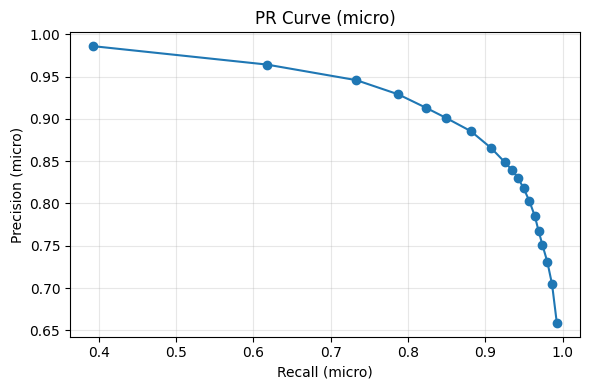

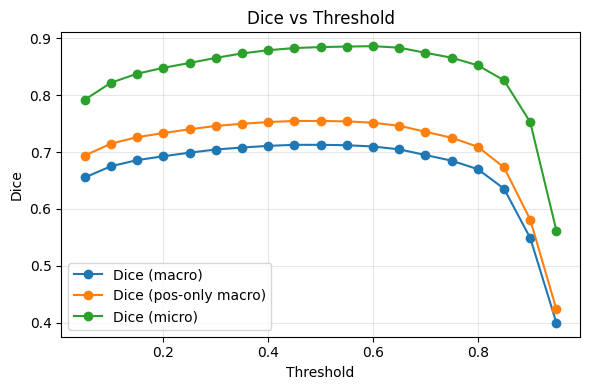

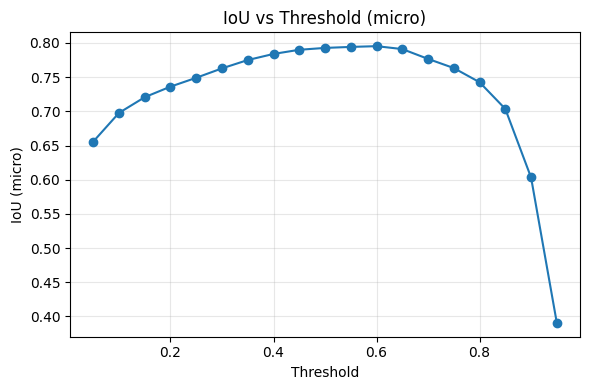

In [12]:
# Plots
import matplotlib.pyplot as plt

# Precision–Recall (micro)
plt.figure(figsize=(6,4))
plt.plot(df_curve["recall_micro"], df_curve["precision_micro"], marker="o")
plt.xlabel("Recall (micro)"); plt.ylabel("Precision (micro)")
plt.title("PR Curve (micro)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "curve_pr_micro.png"), dpi=200)
plt.show()

# Dice vs threshold (macro, positives-only, micro)
plt.figure(figsize=(6,4))
plt.plot(df_curve["thr"], df_curve["dice_macro"], marker="o", label="Dice (macro)")
plt.plot(df_curve["thr"], df_curve["dice_pos"],   marker="o", label="Dice (pos-only macro)")
plt.plot(df_curve["thr"], df_curve["dice_micro"], marker="o", label="Dice (micro)")
plt.xlabel("Threshold"); plt.ylabel("Dice")
plt.title("Dice vs Threshold")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "curve_dice_vs_thr.png"), dpi=200)
plt.show()

# IoU vs threshold (micro)
plt.figure(figsize=(6,4))
plt.plot(df_curve["thr"], df_curve["iou_micro"], marker="o")
plt.xlabel("Threshold"); plt.ylabel("IoU (micro)")
plt.title("IoU vs Threshold (micro)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "curve_iou_vs_thr_micro.png"), dpi=200)
plt.show()

In [13]:
# best by micro Dice
row_best_micro = df_curve.iloc[df_curve["dice_micro"].idxmax()]
# best by precision (micro)
row_best_prec  = df_curve.iloc[df_curve["precision_micro"].idxmax()]
# best by recall (micro)
row_best_rec   = df_curve.iloc[df_curve["recall_micro"].idxmax()]

print("Best micro Dice @thr = {:.3f} -> Dice={:.4f}, IoU={:.4f}, P={:.4f}, R={:.4f}"
      .format(row_best_micro["thr"], row_best_micro["dice_micro"], row_best_micro["iou_micro"],
              row_best_micro["precision_micro"], row_best_micro["recall_micro"]))
print("Best precision (micro) @thr = {:.3f} -> P={:.4f}, R={:.4f}, Dice={:.4f}"
      .format(row_best_prec["thr"], row_best_prec["precision_micro"], row_best_prec["recall_micro"],
              row_best_prec["dice_micro"]))
print("Best recall (micro) @thr = {:.3f} -> R={:.4f}, P={:.4f}, Dice={:.4f}"
      .format(row_best_rec["thr"], row_best_rec["recall_micro"], row_best_rec["precision_micro"],
              row_best_rec["dice_micro"]))

Best micro Dice @thr = 0.600 -> Dice=0.8860, IoU=0.7953, P=0.8655, R=0.9075
Best precision (micro) @thr = 0.950 -> P=0.9858, R=0.3927, Dice=0.5617
Best recall (micro) @thr = 0.050 -> R=0.9925, P=0.6589, Dice=0.7920
